In [224]:
! cd ../data/retrotech && head signals.csv

import random
import pandas as pd
import numpy as np
import sys
sys.path.append('..')
from aips import *
from session_gen import SessionGenerator
import os
from IPython.core.display import display,HTML

"query_id","user","type","target","signal_time"
"u2_0_1","u2","query","nook","2019-07-31 08:49:07.3116"
"u2_1_2","u2","query","rca","2020-05-04 08:28:21.1848"
"u3_0_1","u3","query","macbook","2019-12-22 00:07:07.0152"
"u4_0_1","u4","query","Tv antenna","2019-08-22 23:45:54.1030"
"u5_0_1","u5","query","AC power cord","2019-10-20 08:27:00.1600"
"u6_0_1","u6","query","Watch The Throne","2019-09-18 11:59:53.7470"
"u7_0_1","u7","query","Camcorder","2020-02-25 13:02:29.3089"
"u9_0_1","u9","query","wireless headphones","2020-04-26 04:26:09.7198"
"u10_0_1","u10","query","Xbox","2019-09-13 16:26:12.0132"


In [225]:
def all_sessions():
    import glob
    sessions = pd.concat([pd.read_csv(f, compression='gzip')
                          for f in glob.glob('*_sessions.gz')])
    return sessions.rename(columns={'clicked_doc_id': 'doc_id'})
    
sessions = all_sessions()
sessions

,sess_id,query,rank,doc_id,clicked
0,2,dryer,0.0,12505451713,False
1,2,dryer,1.0,84691226727,True
2,2,dryer,2.0,883049066905,False
3,2,dryer,3.0,14381196320,False
4,2,dryer,4.0,74108056764,False
...,...,...,...,...,...
149995,55001,blue ray,25.0,22265004517,False
149996,55001,blue ray,26.0,885170038875,False
149997,55001,blue ray,27.0,786936817232,False
149998,55001,blue ray,28.0,600603132872,False


In [226]:
def fetch_products(doc_ids):
    import requests
    doc_ids = ["%s" % doc_id for doc_id in doc_ids]
    query = "upc:( " + " OR ".join(doc_ids) + " )"
    params = {'q':  query, 'wt': 'json', 'rows': len(doc_ids)}
    resp = requests.get('http://aips-solr:8983/solr/products/select', params=params)
    df = pd.DataFrame(resp.json()['response']['docs'])
    df['upc'] = df['upc'].astype('int64')
    
    df.insert(0, 'image', df.apply(lambda row: "<img height=\"100\" src=\"" + img_path_for_upc(row['upc']) + "\">", axis=1))
    
    return df

def render(judged, grade_col='ctr', label=""):
    """ Render the computed judgments alongside the productns and description data"""
    w_prods = judged.merge(products, left_on='doc_id', right_on='upc', how='left')

    w_prods = w_prods[[grade_col, 'image', 'upc', 'name', 'shortDescription']]

    return HTML(f"<h1>{label}</h1>" + w_prods.to_html(escape=False))

products = fetch_products(doc_ids=sessions['doc_id'].unique())

# Listing 11.03

Viewing session 2 of query `transformers dark of the moon` in retrotech

In [227]:
QUERY='transformers dark of the moon'
query_sessions = sessions[sessions['query'] == QUERY]
query_sessions[query_sessions['sess_id'] == 2]

,sess_id,query,rank,doc_id,clicked
0,2,transformers dark of the moon,0.0,47875842328,False
1,2,transformers dark of the moon,1.0,24543701538,True
2,2,transformers dark of the moon,2.0,25192107191,False
3,2,transformers dark of the moon,3.0,47875841420,False
4,2,transformers dark of the moon,4.0,786936817218,False
5,2,transformers dark of the moon,5.0,47875842335,False
6,2,transformers dark of the moon,6.0,47875841406,False
7,2,transformers dark of the moon,7.0,97360810042,False
8,2,transformers dark of the moon,8.0,24543750949,False
9,2,transformers dark of the moon,9.0,36725235564,False


# Listing 11.04

Comparing the above session to a slightly different one

In [228]:
QUERY='transformers dark of the moon'
query_sessions = sessions[sessions['query'] == QUERY]
query_sessions[query_sessions['sess_id'] == 5]

,sess_id,query,rank,doc_id,clicked
45,5,transformers dark of the moon,0.0,47875842328,True
46,5,transformers dark of the moon,1.0,24543701538,False
47,5,transformers dark of the moon,2.0,25192107191,False
48,5,transformers dark of the moon,3.0,400192926087,False
49,5,transformers dark of the moon,4.0,786936817218,False
50,5,transformers dark of the moon,5.0,47875842335,False
51,5,transformers dark of the moon,6.0,47875841406,False
52,5,transformers dark of the moon,7.0,97360810042,False
53,5,transformers dark of the moon,8.0,24543750949,False
54,5,transformers dark of the moon,9.0,36725235564,False


# Listing 11.05

Simple CTR based judgments for our query

In [229]:
QUERY='transformers dark of the moon'
query_sessions = sessions[sessions['query'] == QUERY]

click_counts = query_sessions.groupby('doc_id')['clicked'].sum()
doc_counts = query_sessions.groupby('doc_id')['sess_id'].nunique()
ctrs = click_counts / doc_counts

render(ctrs.to_frame(name='ctr').sort_values('ctr', ascending=False),
       grade_col='ctr',
       label="Click-Thru-Rate Judgments")

,ctr,image,upc,name,shortDescription
0,0.0824,,97360810042,Transformers: Dark of the Moon - Blu-ray Disc,\N
1,0.0734,,47875842328,Transformers: Dark of the Moon Stealth Force Edition - Nintendo Wii,Transform into an epic hero or a vehicular villain
2,0.0434,,47875841420,Transformers: Dark of the Moon Decepticons - Nintendo DS,Transform into an epic hero or a vehicular villain
3,0.0364,,24543701538,The A-Team - Widescreen Dubbed Subtitle AC3 - Blu-ray Disc,\N
4,0.0352,,25192107191,Fast Five - Widescreen - Blu-ray Disc,\N
5,0.0236,,786936817218,Pirates Of The Caribbean: On Stranger Tides (3-D) - Blu-ray 3D,\N
6,0.0192,,97363560449,Transformers: Dark of the Moon - Widescreen Dubbed Subtitle - DVD,\N
7,0.0160,,47875841406,Transformers: Dark of the Moon Autobots - Nintendo DS,Transform into an epic hero or a vehicular villain
8,0.0124,,400192926087,Transformers: Dark of the Moon - Original Soundtrack - CD,\N
9,0.0106,,47875842335,Transformers: Dark of the Moon Stealth Force Edition - Nintendo 3DS,Transform into an epic hero or a vehicular villain


Repeating Listing 11.4 but for `QUERY='dryer'`

In [230]:
QUERY='dryer'
query_sessions = sessions[sessions['query'] == QUERY]

click_counts = query_sessions.groupby('doc_id')['clicked'].sum()
doc_counts = query_sessions.groupby('doc_id')['sess_id'].nunique()
ctrs = click_counts / doc_counts

render(ctrs.to_frame(name='ctr').sort_values('ctr', ascending=False),
       grade_col='ctr',
       label="Click-Thru-Rate Judgments")

,ctr,image,upc,name,shortDescription
0,0.1608,,84691226727,GE - 6.0 Cu. Ft. 3-Cycle Electric Dryer - White,Rotary electromechanical controls; 3 cycles; 3 heat selections; DuraDrum interior; Quiet-By-Design
1,0.0816,,84691226703,Hotpoint - 6.0 Cu. Ft. 3-Cycle Electric Dryer - White-on-White,Rotary controls; 3 cycles; 3 temperature settings; DuraDrum interior
2,0.0710,,12505451713,Frigidaire - Semi-Rigid Dryer Vent Kit - Silver,Expandable vent; custom fitted ends and clamps
3,0.0576,,783722274422,The Independent - Widescreen Subtitle - DVD,\N
4,0.0572,,883049066905,Whirlpool - Affresh Washer Cleaner,Package include 3 tablets; removes and prevents odor-causing residue; compatible with all high-efficiency washers
5,0.0552,,77283045400,Hello Kitty - Hair Dryer - Pink,1875 watts of power; high and low heat settings; cool shot button; detachable styling nozzle
6,0.0546,,74108056764,Conair - Infiniti Ionic Cord-Keeper Hair Dryer - Light Purple,1875 watts; dual voltage; 2 heat and speed settings
7,0.0540,,665331101927,Everything in Static - CD,\N
8,0.0536,,12505525766,Smart Choice - 6' 30 Amp 3-Prong Dryer Cord,Heavy-duty PVC insulation; strain relief safety clamp
9,0.0470,,74108096487,Conair - Infiniti Cord-Keeper Professional Tourmaline Ionic Hair Dryer - Fuchsia,Tourmaline ceramic technology; ionic technology; 1875 watts; Cool Shot function; 3 heat settings; 2 speed settings; 5' retractable cord; includes diffuser


## Listing 11.6

A set of global CTRs

In [231]:
num_sessions = len(sessions['sess_id'].unique())
global_ctrs = sessions.groupby('rank')['clicked'].sum() / num_sessions
global_ctrs

rank
0.0     0.249727
1.0     0.142673
2.0     0.084218
3.0     0.063073
4.0     0.056255
5.0     0.042255
6.0     0.033236
7.0     0.038000
8.0     0.020964
9.0     0.017364
10.0    0.013982
11.0    0.018582
12.0    0.015982
13.0    0.014509
14.0    0.012327
15.0    0.010200
16.0    0.011782
17.0    0.007891
18.0    0.007273
19.0    0.008145
20.0    0.006236
21.0    0.004473
22.0    0.005455
23.0    0.004982
24.0    0.005309
25.0    0.004364
26.0    0.005055
27.0    0.004691
28.0    0.005000
29.0    0.005400
Name: clicked, dtype: float64

## Listing 11.7

We look at the documents for our query, and notice that certain ones tend to appear higher and others tend to appear lower. If irrelevant ones dominate the top listings, position bias will dominate our training data

In [232]:
QUERY='transformers dark of the moon'
query_sessions = sessions[sessions['query'] == QUERY]

avg_rank = query_sessions.groupby('doc_id')['rank'].mean()

avg_rank

doc_id
24543701538      1.8626
24543750949      7.8626
25192107191      2.6596
36725235564      8.6854
47875841369      9.5796
47875841406      6.1378
47875841420      3.5344
47875842328      0.9808
47875842335      5.2776
93624956037     11.3298
97360810042      7.0130
97363532149     12.1494
97363560449     10.4304
400192926087    13.0526
786936817218     4.4444
Name: rank, dtype: float64

In [233]:
render(avg_rank.reset_index().sort_values('rank'), grade_col='rank', label="Typical Search Session")

,rank,image,upc,name,shortDescription
0,0.9808,,47875842328,Transformers: Dark of the Moon Stealth Force Edition - Nintendo Wii,Transform into an epic hero or a vehicular villain
1,1.8626,,24543701538,The A-Team - Widescreen Dubbed Subtitle AC3 - Blu-ray Disc,\N
2,2.6596,,25192107191,Fast Five - Widescreen - Blu-ray Disc,\N
3,3.5344,,47875841420,Transformers: Dark of the Moon Decepticons - Nintendo DS,Transform into an epic hero or a vehicular villain
4,4.4444,,786936817218,Pirates Of The Caribbean: On Stranger Tides (3-D) - Blu-ray 3D,\N
5,5.2776,,47875842335,Transformers: Dark of the Moon Stealth Force Edition - Nintendo 3DS,Transform into an epic hero or a vehicular villain
6,6.1378,,47875841406,Transformers: Dark of the Moon Autobots - Nintendo DS,Transform into an epic hero or a vehicular villain
7,7.0130,,97360810042,Transformers: Dark of the Moon - Blu-ray Disc,\N
8,7.8626,,24543750949,X-Men: First Class - Widescreen Dubbed Subtitle AC3 - Blu-ray Disc,\N
9,8.6854,,36725235564,"Samsung - 40"" Class - LCD - 1080p - 120Hz - HDTV",\N


In [234]:
QUERY='dryer'
query_sessions = sessions[sessions['query'] == QUERY]

avg_rank = query_sessions.groupby('doc_id')['rank'].mean()

avg_rank
render(avg_rank.reset_index().sort_values('rank'), grade_col='rank', label="Typical Search Session for 'dryer'")

,rank,image,upc,name,shortDescription
0,1.9124,,12505451713,Frigidaire - Semi-Rigid Dryer Vent Kit - Silver,Expandable vent; custom fitted ends and clamps
1,2.8290,,84691226727,GE - 6.0 Cu. Ft. 3-Cycle Electric Dryer - White,Rotary electromechanical controls; 3 cycles; 3 heat selections; DuraDrum interior; Quiet-By-Design
2,3.5726,,883049066905,Whirlpool - Affresh Washer Cleaner,Package include 3 tablets; removes and prevents odor-causing residue; compatible with all high-efficiency washers
3,4.4552,,84691226703,Hotpoint - 6.0 Cu. Ft. 3-Cycle Electric Dryer - White-on-White,Rotary controls; 3 cycles; 3 temperature settings; DuraDrum interior
4,5.1276,,74108056764,Conair - Infiniti Ionic Cord-Keeper Hair Dryer - Light Purple,1875 watts; dual voltage; 2 heat and speed settings
5,5.9318,,77283045400,Hello Kitty - Hair Dryer - Pink,1875 watts of power; high and low heat settings; cool shot button; detachable styling nozzle
6,6.7610,,783722274422,The Independent - Widescreen Subtitle - DVD,\N
7,7.5138,,665331101927,Everything in Static - CD,\N
8,8.3308,,14381196320,The Mind Snatchers - DVD,\N
9,9.1230,,74108096487,Conair - Infiniti Cord-Keeper Professional Tourmaline Ionic Hair Dryer - Fuchsia,Tourmaline ceramic technology; ionic technology; 1875 watts; Cool Shot function; 3 heat settings; 2 speed settings; 5' retractable cord; includes diffuser


# Listing 11.8

Compute CTR at each rank

In [235]:
QUERY='transformers dark of the moon'
query_sessions = sessions[sessions['query'] == QUERY]

sessions_by_doc_and_rank = query_sessions.groupby(['doc_id', 'rank'])

clicks_at_each_rank = sessions_by_doc_and_rank['clicked'].sum()
appears_at_each_rank = sessions_by_doc_and_rank['sess_id'].nunique()

ctr_per_rank = clicks_at_each_rank / appears_at_each_rank


doc_id        rank
24543701538   0.0     0.000000
              1.0     0.040434
              2.0     0.000000
              3.0     0.058824
              4.0     0.034483
                        ...   
786936817218  10.0    0.000000
              11.0    0.000000
              12.0    0.018519
              13.0    0.017241
              14.0    0.000000
Length: 225, dtype: float64

In [ ]:
# Why is 'dryer' album ranked so hi by COEC?
ctr_per_rank[]

# Listing 11.9

Showing coecs calculation by taking ctr_per_rank with respect to global_ctrs. We then see the average coec score per doc which gives us a sense of whether it over or underperforms for its rank

In [236]:
coecs_per_rank = ctr_per_rank / global_ctrs
coecs = coecs_per_rank.groupby('doc_id').mean()

coecs

doc_id
24543701538     0.194587
24543750949     0.229005
25192107191     0.315513
36725235564     0.396350
47875841369     0.233285
47875841406     0.203407
47875841420     0.680696
47875842328     0.531608
47875842335     0.121791
93624956037     0.579244
97360810042     3.035267
97363532149     0.599679
97363560449     0.884910
400192926087    0.714086
786936817218    0.510963
dtype: float64

In [237]:
coec_frame = coecs.to_frame(name='coec_score').sort_values('coec_score', ascending=False)

render(coec_frame, grade_col='coec_score', label=f"Clicks Over Expected Clicks for '{QUERY}'")

,coec_score,image,upc,name,shortDescription
0,3.035267,,97360810042,Transformers: Dark of the Moon - Blu-ray Disc,\N
1,0.884910,,97363560449,Transformers: Dark of the Moon - Widescreen Dubbed Subtitle - DVD,\N
2,0.714086,,400192926087,Transformers: Dark of the Moon - Original Soundtrack - CD,\N
3,0.680696,,47875841420,Transformers: Dark of the Moon Decepticons - Nintendo DS,Transform into an epic hero or a vehicular villain
4,0.599679,,97363532149,Transformers: Revenge of the Fallen - Widescreen Dubbed Subtitle - DVD,\N
5,0.579244,,93624956037,Transformers: Dark of the Moon - Original Soundtrack - CD,\N
6,0.531608,,47875842328,Transformers: Dark of the Moon Stealth Force Edition - Nintendo Wii,Transform into an epic hero or a vehicular villain
7,0.510963,,786936817218,Pirates Of The Caribbean: On Stranger Tides (3-D) - Blu-ray 3D,\N
8,0.396350,,36725235564,"Samsung - 40"" Class - LCD - 1080p - 120Hz - HDTV",\N
9,0.315513,,25192107191,Fast Five - Widescreen - Blu-ray Disc,\N


In [238]:
QUERY='dryer'
query_sessions = sessions[sessions['query'] == QUERY]

sessions_by_doc_and_rank = query_sessions.groupby(['doc_id', 'rank'])

clicks_at_each_rank = sessions_by_doc_and_rank['clicked'].sum()
appears_at_each_rank = sessions_by_doc_and_rank['sess_id'].nunique()

ctr_per_rank = clicks_at_each_rank / appears_at_each_rank

coecs_per_rank = ctr_per_rank / global_ctrs
coecs = coecs_per_rank.groupby('doc_id').mean()

coec_frame = coecs.to_frame(name='coec_score').sort_values('coec_score', ascending=False)

render(coec_frame, grade_col='coec_score', label=f"Clicks Over Expected Clicks for '{QUERY}'")

,coec_score,image,upc,name,shortDescription
0,2.545860,,12505525766,Smart Choice - 6' 30 Amp 3-Prong Dryer Cord,Heavy-duty PVC insulation; strain relief safety clamp
1,2.338978,,665331101927,Everything in Static - CD,\N
2,2.143096,,74108007469,Conair - 1875-Watt Folding Handle Hair Dryer - Blue,2 heat/speed settings; cool shot button; dual voltage; professional-length line cord
3,2.111542,,48231011396,LG - 3.5 Cu. Ft. 7-Cycle High-Efficiency Washer - White,ENERGY STAR QualifiedDigital controls; 7 cycles; SpeedWash cycle; 9 wash options; delay-wash; SenseClean system; 6Motion technology; TrueBalance antivibration system
4,1.896590,,856751002097,Practecol - Dryer Balls (2-Pack),"Suitable for use on most dry cycles; reduces lint, static and wrinkles; improves heat circulation; 2-pack"
5,1.871093,,783722274422,The Independent - Widescreen Subtitle - DVD,\N
6,1.840098,,36725578241,Samsung - 7.3 Cu. Ft. 7-Cycle Electric Dryer - White,Soft-touch dial controls; 7 preset drying cycles; 4 temperature settings; powdercoat drum; noise reduction package
7,1.797944,,14381196320,The Mind Snatchers - DVD,\N
8,1.767062,,74108096487,Conair - Infiniti Cord-Keeper Professional Tourmaline Ionic Hair Dryer - Fuchsia,Tourmaline ceramic technology; ionic technology; 1875 watts; Cool Shot function; 3 heat settings; 2 speed settings; 5' retractable cord; includes diffuser
9,1.695407,,48231011402,LG - 7.1 Cu. Ft. 7-Cycle Electric Dryer - White,Electronic controls with LED display; 7 cycles; Dial-A-Cycle option; sensor dry system; 5 temperature levels; 5 drying levels; NeveRust drum; LoDecibel quiet operation


In [269]:
df = ctr_per_rank.reset_index()
df[df['doc_id']==665331101927]

clicks = clicks_at_each_rank.reset_index()
album_clicks = clicks[clicks['doc_id'] == 665331101927]

appears = appears_at_each_rank.reset_index()
album_appears = appears[appears['doc_id'] == 665331101927]

album_appears

,doc_id,rank,sess_id
300,665331101927,0.0,57
301,665331101927,1.0,44
302,665331101927,2.0,47
303,665331101927,3.0,59
304,665331101927,4.0,50
305,665331101927,5.0,60
306,665331101927,6.0,66
307,665331101927,7.0,3990
308,665331101927,8.0,55
309,665331101927,9.0,53


In [268]:
global_ctrs

rank
0.0     0.249727
1.0     0.142673
2.0     0.084218
3.0     0.063073
4.0     0.056255
5.0     0.042255
6.0     0.033236
7.0     0.038000
8.0     0.020964
9.0     0.017364
10.0    0.013982
11.0    0.018582
12.0    0.015982
13.0    0.014509
14.0    0.012327
15.0    0.010200
16.0    0.011782
17.0    0.007891
18.0    0.007273
19.0    0.008145
20.0    0.006236
21.0    0.004473
22.0    0.005455
23.0    0.004982
24.0    0.005309
25.0    0.004364
26.0    0.005055
27.0    0.004691
28.0    0.005000
29.0    0.005400
Name: clicked, dtype: float64

In [298]:

import matplotlib.pyplot as plt
import numpy as np
# if using a Jupyter notebook, includue:
%matplotlib inline

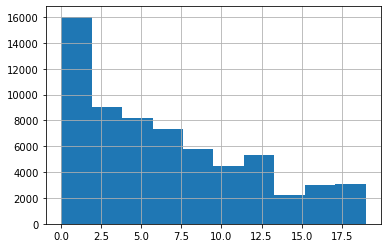

In [300]:
# Mark the last click on each query's session
QUERY='dryer'
sdbn_sessions = sessions[sessions['query'] == QUERY].copy().set_index('sess_id')

#last_clicks = query_sessions[query_sessions['clicked']].groupby(['sess_id', 'clicked'])['rank'].max()

last_click_per_session = sdbn_sessions.groupby(['clicked', 'sess_id'])['rank'].max()[True]

sdbn_sessions['last_click_rank'] = last_click_per_session
sdbn_sessions['examined'] = sdbn_sessions['rank'] <= sdbn_sessions['last_click_rank']

sdbn_sessions['last_click_rank'].hist()


In [245]:


clicks_per_sess = query_sessions[query_sessions['clicked']].groupby(['sess_id'])['clicked'].sum()

last_clicks = query_sessions[query_sessions['clicked']].groupby(['sess_id', 'clicked'])['rank'].max().reset_index()
last_clicks = last_clicks.rename(columns={'rank': 'last_click_rank'})[['sess_id','last_click_rank']]

last_clicks[last_clicks['sess_id'].isin(clicks_per_sess.index)]

,sess_id,last_click_rank
0,2,12.0
1,3,9.0
2,4,11.0
3,6,1.0
4,8,1.0
...,...,...
3219,4995,0.0
3220,4997,1.0
3221,4998,1.0
3222,4999,6.0


In [270]:
sdbn_sessions = query_sessions.merge(last_clicks, on='sess_id', how='left')
sdbn_sessions = sdbn_sessions[sdbn_sessions['last_click_rank'].notna()]

sdbn_sessions

,sess_id,query,rank,doc_id,clicked,last_click_rank
0,2,dryer,0.0,12505451713,False,12.0
1,2,dryer,1.0,84691226727,True,12.0
2,2,dryer,2.0,883049066905,False,12.0
3,2,dryer,3.0,14381196320,False,12.0
4,2,dryer,4.0,74108056764,False,12.0
...,...,...,...,...,...,...
99995,5001,dryer,15.0,36725561977,True,15.0
99996,5001,dryer,16.0,36725578241,False,15.0
99997,5001,dryer,17.0,12505527456,False,15.0
99998,5001,dryer,18.0,77283045400,False,15.0


In [281]:
sdbn_sessions['examined'] = sdbn_sessions['rank'] <= sdbn_sessions['last_click_rank']
sdbn_sessions['grade'] = sdbn_sessions['clicked'] & sdbn_sessions['examined']

sdbn_sessions

,sess_id,query,rank,doc_id,clicked,last_click_rank,satisfied,attractive,examined,grade
0,2,dryer,0.0,12505451713,False,12.0,False,True,True,False
1,2,dryer,1.0,84691226727,True,12.0,False,True,True,True
2,2,dryer,2.0,883049066905,False,12.0,False,True,True,False
3,2,dryer,3.0,14381196320,False,12.0,False,True,True,False
4,2,dryer,4.0,74108056764,False,12.0,False,True,True,False
...,...,...,...,...,...,...,...,...,...,...
99995,5001,dryer,15.0,36725561977,True,15.0,True,True,True,True
99996,5001,dryer,16.0,36725578241,False,15.0,False,True,False,False
99997,5001,dryer,17.0,12505527456,False,15.0,False,True,False,False
99998,5001,dryer,18.0,77283045400,False,15.0,False,True,False,False


In [246]:
#sdbn
# For each session, find last click
# - everything above last click considered examined
# - everything clicked counted towards attractive
# - satisfaction is clicks / last clicks
                 
sdbn_sessions = query_sessions.merge(last_clicks, on='sess_id', how='left')
sdbn_sessions = sdbn_sessions[sdbn_sessions['last_click_rank'].notna()]

sdbn_sessions['satisfied'] = sdbn_sessions.apply(lambda row: row['rank'] == row['last_click_rank'], axis=1)
sdbn_sessions['attractive'] = sdbn_sessions.apply(lambda row: row['rank'] <= row['last_click_rank'] and row['clicked'], axis=1)
sdbn_sessions['examined'] = sdbn_sessions.apply(lambda row: row['rank'] <= row['last_click_rank'], axis=1)



#    df.insert(0, 'image', df.apply(lambda row: "<img height=\"100\" src=\"" + img_path_for_upc(row['upc']) + "\">", axis=1))
# sdbn_sessions[sdbn_sessions['sess_id'] == 15]

In [247]:
# Clicks over examines
sdbn = sdbn_sessions[sdbn_sessions['examined']].groupby('doc_id').sum()

sdbn['attractiveness'] = sdbn['attractive'] / sdbn['examined']
sdbn['satisfaction'] = sdbn['satisfied'] / sdbn['examined']

sdbn = sdbn.sort_values('attractiveness', ascending=False)

render(sdbn, grade_col='attractiveness', label="Attractive Results")

,attractiveness,image,upc,name,shortDescription
0,0.411765,,856751002097,Practecol - Dryer Balls (2-Pack),"Suitable for use on most dry cycles; reduces lint, static and wrinkles; improves heat circulation; 2-pack"
1,0.392435,,48231011396,LG - 3.5 Cu. Ft. 7-Cycle High-Efficiency Washer - White,ENERGY STAR QualifiedDigital controls; 7 cycles; SpeedWash cycle; 9 wash options; delay-wash; SenseClean system; 6Motion technology; TrueBalance antivibration system
2,0.316411,,84691226727,GE - 6.0 Cu. Ft. 3-Cycle Electric Dryer - White,Rotary electromechanical controls; 3 cycles; 3 heat selections; DuraDrum interior; Quiet-By-Design
3,0.293785,,74108007469,Conair - 1875-Watt Folding Handle Hair Dryer - Blue,2 heat/speed settings; cool shot button; dual voltage; professional-length line cord
4,0.275154,,12505525766,Smart Choice - 6' 30 Amp 3-Prong Dryer Cord,Heavy-duty PVC insulation; strain relief safety clamp
5,0.272537,,36725578241,Samsung - 7.3 Cu. Ft. 7-Cycle Electric Dryer - White,Soft-touch dial controls; 7 preset drying cycles; 4 temperature settings; powdercoat drum; noise reduction package
6,0.260391,,48231011402,LG - 7.1 Cu. Ft. 7-Cycle Electric Dryer - White,Electronic controls with LED display; 7 cycles; Dial-A-Cycle option; sensor dry system; 5 temperature levels; 5 drying levels; NeveRust drum; LoDecibel quiet operation
7,0.257009,,12505527456,"Smart Choice - 1/2"" Safety+PLUS Stainless-Steel Gas Dryer Connector","Safety+PLUS automatic shut-off valve; leak detection solution; pipe thread sealant; 60,500 BTU; CSA approved"
8,0.214221,,74108096487,Conair - Infiniti Cord-Keeper Professional Tourmaline Ionic Hair Dryer - Fuchsia,Tourmaline ceramic technology; ionic technology; 1875 watts; Cool Shot function; 3 heat settings; 2 speed settings; 5' retractable cord; includes diffuser
9,0.208042,,36725561977,Samsung - 3.5 Cu. Ft. 6-Cycle High-Efficiency Washer - White,ENERGY STAR QualifiedSoft dial touch pad controls; 6 cycles; delay-start; child lock; Vibration Reduction Technology


In [248]:
sdbn = sdbn.sort_values('satisfaction', ascending=False)

render(sdbn, judgments_col='satisfaction', label="Satisfying? Results")

TypeError: render() got an unexpected keyword argument 'judgments_col'